In [27]:
# import fft_interp_wrappers as wrap
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.interpolate import InterpolatedUnivariateSpline, CubicSpline
import datetime
import os

def scale_fig_size(x_len):
    # kinda arbitrary scaling function to turn array length into a good graph length
    return (int(np.log2(x_len)),4)

def mp3_to_samples(filename,rate=None,flac=False):
    """
    Returns
    samples, sample_rate: samples of the mp3 and the sample rate
    """
    if flac:
        return sf.read(filename)
    return librosa.load(filename,sr=rate)

def samples_to_freq(sample_arr):
    """
    Returns
    mag_arr: 2d array of magnitudes in frequency-time
    """
    freq_arr = librosa.stft(sample_arr)
    mag_arr = np.abs(freq_arr) # |z| = sqrt(k**2 + j**2) reduce complex component
    return mag_arr,freq_arr

def graph_spectro(freq_amp,sr,title=None,figsize=None,save_n=None,log=True):
    """
    Display a spectrogram of the provided freq_amp data

    Parameters
    ----------
    freq_amp : list|np.array
        2D array in frequency domain to graph
        
    sr: int
        The sample rate for the provided samples. This is used to label seconds.
    
    title : str
        A string to title the graphs if provided
        
    figsize: (int,int)
        The aspect and size of the graph to produce
        
    save_n: str
        A string name to save the graph under if provided
    
    """
    plt.subplots(figsize=figsize)
    librosa.display.specshow(librosa.amplitude_to_db(freq_amp, ref=np.max), sr=sr, x_axis='time', y_axis=('log' if log else 'hz'))
    plt.colorbar(format='%+2.0f dB')
    plt.title(title if title else 'Spectrogram')
    if save_n:
        plt.savefig(save_n)
    plt.show()

def lazy_graph(filename,figsize=None,save_n=None):
    """
    All in one helper to import file, FFT, and graph the result
    """
    samp,rate = mp3_to_samples(filename)
    graph_spectro(samples_to_freq(samp),rate,figsize=figsize,save_n=save_n)

def get_interp_fun(samples, degree=3):
    """
    Returns
    spl() - interpolating function for samples
    """
    x = np.arange(0,2*len(samples),2)
    # return InterpolatedUnivariateSpline(x,samples)#,k=5)
    return CubicSpline(x,samples)

def remove_half_samples(samples):
    """
    Returns
    samples at only even indices (for lossy interpolating odd samples)
    """
    return samples[::2]

def interp_odd_samples(samples, spl, length):
    """
    Efficiently interlace samples with interpolated values using spl() to reconstruct an array of length
    Returns
    inter_samples - interlaced sample and interpolated values
    """
    even_idx = np.arange(0, length, 2)
    odd_idx = np.arange(1, length, 2)
    
    odd_elms = spl(odd_idx)
    
    inter_samples = np.empty(length)
    inter_samples[even_idx] = samples
    inter_samples[odd_idx] = odd_elms
    return inter_samples

def freq_to_samples(freq_arr):
    """
    Take frequency domain and istft back to amplidute samples
    """
    return librosa.istft(freq_arr)

def save_samples_to_wav(samples,sr,filename):
    """
    Take samples and save to .wav audio file.
    Not saving to mp3 because mp3 is lossy. No point.
    """
    sf.write(filename,samples,sr)

def RMSE(diff):
    return np.sqrt(np.mean((diff)**2))

def graph_samples(samples, sr, title=None, interval=None, figsize=None,save_n=None):
    """
    Plot the samples over time

    Parameters
    ----------
    samples : list|np.array
        Array of samples to graph
        
    sr : int
        The sample rate for the provided samples. This is used to label seconds.

    title : str
        A string to title the graphs if provided
    
    interval : (int,int)
        The start and end index of the chunk being processed. This is just to label the axis
        
    figsize : (int,int)
        The aspect and size of the graph to produce
        
    save_n : str
        A string name to save the graph under if provided
    """
    plt.subplots(figsize=figsize)
    if interval:
        x = np.arange(*interval)
    else:
        x = np.arange(len(samples))
    x_labels = np.vectorize(lambda i: str(datetime.timedelta(seconds=int(i//sr)))[2:])(x[::len(x)//8])
    plt.plot(x,samples)
    plt.xticks(x[::len(x)//8], x_labels)
    if title:
        plt.title(title)
    if save_n:
        plt.savefig(save_n)
    plt.show()

def full_pipeline(filename, save_dir=None, testname=None, chunks=1,chunk_num=0,flac=False):
    """
    Automated testing function
    
    Parameters
    ----------
    filename : str
        The filename of the .mp3 to run the test on.
        
    save_dir=None : str
        The name of the directory to create and save test graphs/results into. If none provided, nothing is saved.
        
    testname=None : str
        A name for the set of tests. This will title graphs and prepend filenames.
        
    chunks=1 : int
        The number of chunks to divide the samples into. This is for reducing the amount of data to be processed. For example, chunks=4 will run the test on 1/4th of the file.
        
    chunk_num : int
        The index of the chunk to process. If chunk != 0,1 chunk_num will select which chunk in series to process. For example, chunks=4 and chunk_num=3 will run the test on the last 1/4 of the file.
    """
    if not testname:
        testname = filename
    smps,sr = mp3_to_samples(filename,flac=flac)
    smps = np.array(smps)
    n = len(smps)
    chunk_interval = None
    # take the chunk_num-th chunk of smps divided into chunks
    if chunks not in [0,1]: # no div by 0
        if chunks < 0: # no negs, just flip sign
            chunks *= -1
        chunksize = n//chunks
        start_idx = chunk_num*chunksize
        end_idx = (chunk_num+1)*chunksize
        if np.diff((start_idx,end_idx))[0] % 2 == 1:
            end_idx += 1
        smps = smps[start_idx:end_idx]
        chunk_interval = (start_idx,end_idx)
    n = len(smps)
    # Cut resolution on samples
    half_smps = remove_half_samples(smps)
    # Interpolate reduced samples
    spline = get_interp_fun(half_smps)
    # Reconstruct "full" resolution samples with values from quadratic spline
    recon_smps = interp_odd_samples(half_smps,spline,n)

    diff_samples = smps - recon_smps

    print(f'RMSE of reconstruction: {RMSE(diff_samples)}')
    
    print("Sample reconstruction complete -> starting FFT")
    
    # FFT on reconstructed samples
    fmag_recon,freq_recon = samples_to_freq(recon_smps)
    # FFT on original samples
    fmag_orig,freq_orig = samples_to_freq(smps)
    # FFT on diff samples
    fmag_diff,freq_diff = samples_to_freq(diff_samples)
    
    print("FFT Complete -> constructing charts")
    
    # # Calculate differences between the original and reconstruction in both domains
    # fmag_diff, diff = fmag_orig-fmag_recon, freq_orig-freq_recon
    
    # # Create new sample array with iFFT from the difference
    # diff_samples = freq_to_samples(diff)
    
    save_n = None
    if save_dir:
        os.makedirs(save_dir,exist_ok=True)
        save_n = f'{save_dir}/{testname}_'
        # save dfference .wav
        save_samples_to_wav(diff_samples, sr, save_n+'difference.wav')
    
    graph_samples(diff_samples, 
                sr, 
                title=f'{testname}: Difference Samples', 
                interval=(chunk_interval[0],chunk_interval[0]+len(diff_samples)) if chunk_interval else None, 
                figsize=scale_fig_size(n), 
                save_n=(save_n+'diff_samples.png' if save_n else None)
               )
    graph_samples(smps, 
                sr, 
                title=f'{testname}: Original Samples', 
                interval=chunk_interval, 
                figsize=scale_fig_size(n), 
                save_n=(save_n+'orig_samples.png' if save_n else None)
               )
    graph_samples(recon_smps, 
                sr, 
                title=f'{testname}: Reconstructed Samples', 
                interval=chunk_interval, 
                figsize=scale_fig_size(n), 
                save_n=(save_n+'recon_samples.png' if save_n else None)
               )

    graph_spectro(fmag_diff,
                  sr, 
                  title=f'{testname}: Difference Spectrogram',
                  figsize=scale_fig_size(n), 
                  save_n=(save_n+'diff_spectro.png' if save_n else None),
                  log=False)
    graph_spectro(fmag_orig,
                  sr,
                  title=f'{testname}: Original Spectrogram',
                  figsize=scale_fig_size(n), 
                  save_n=(save_n+'orig_spectro.png' if save_n else None))
    graph_spectro(fmag_recon,
                  sr,
                  title=f'{testname}: Reconstructed Spectrogram',
                  figsize=scale_fig_size(n), 
                  save_n=(save_n+'recon_spectro.png' if save_n else None))



RMSE of reconstruction: 0.01050583923262463
Sample reconstruction complete -> starting FFT
FFT Complete -> constructing charts


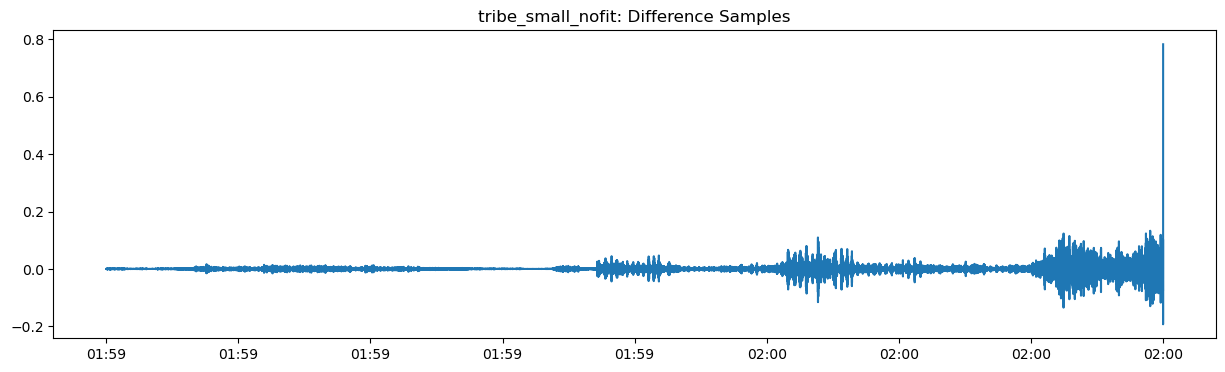

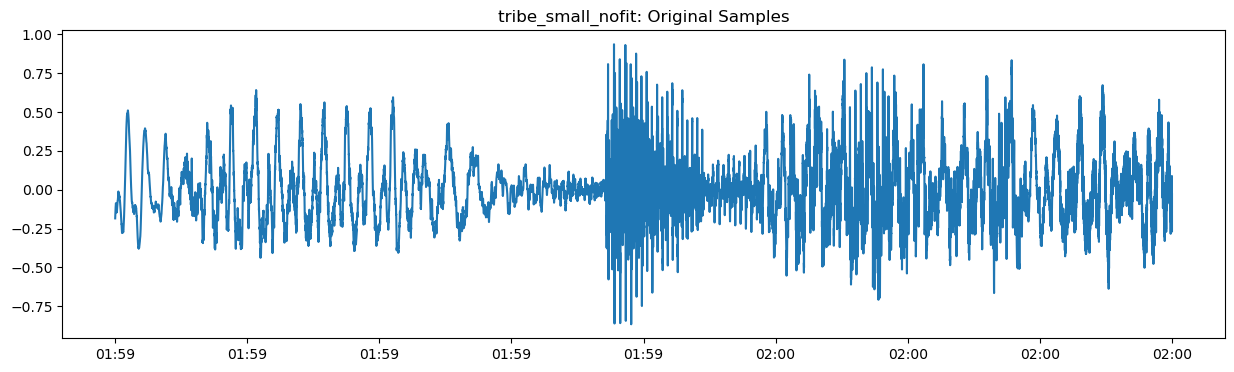

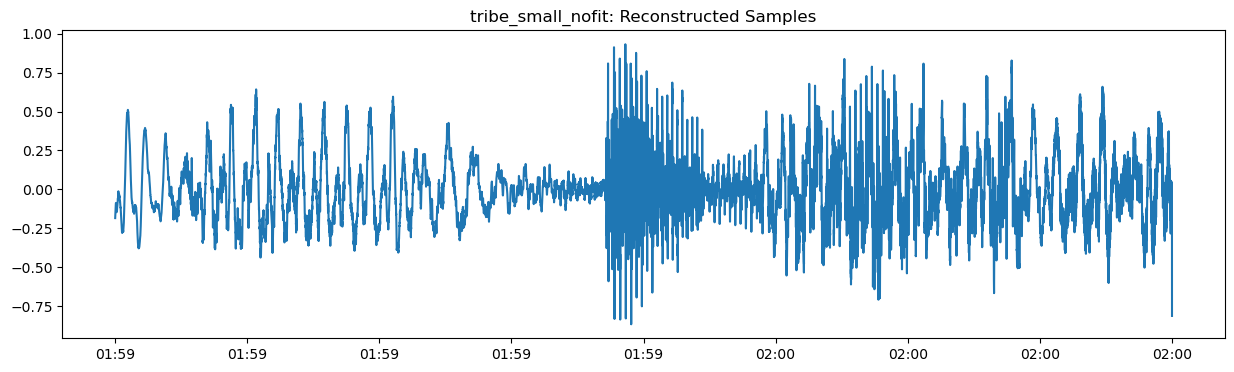

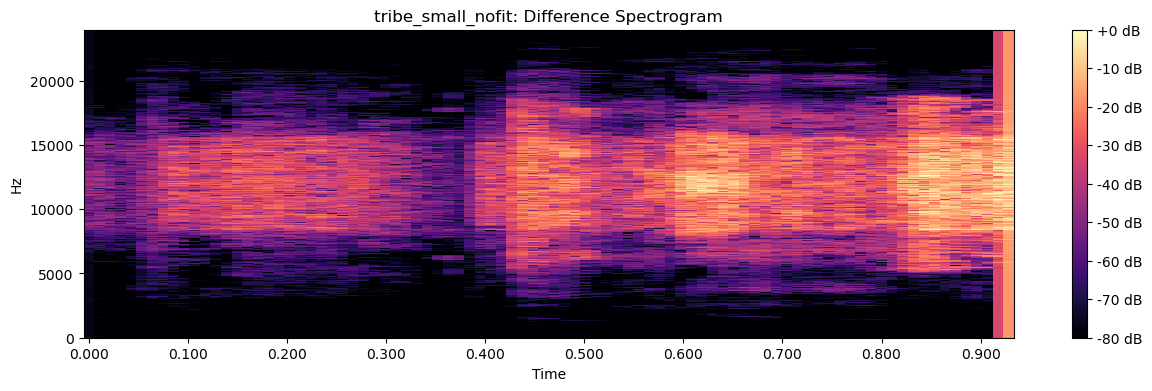

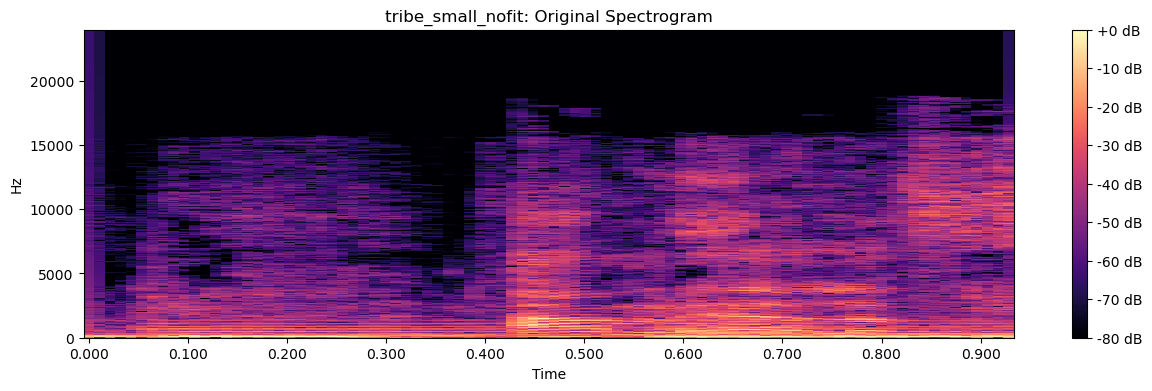

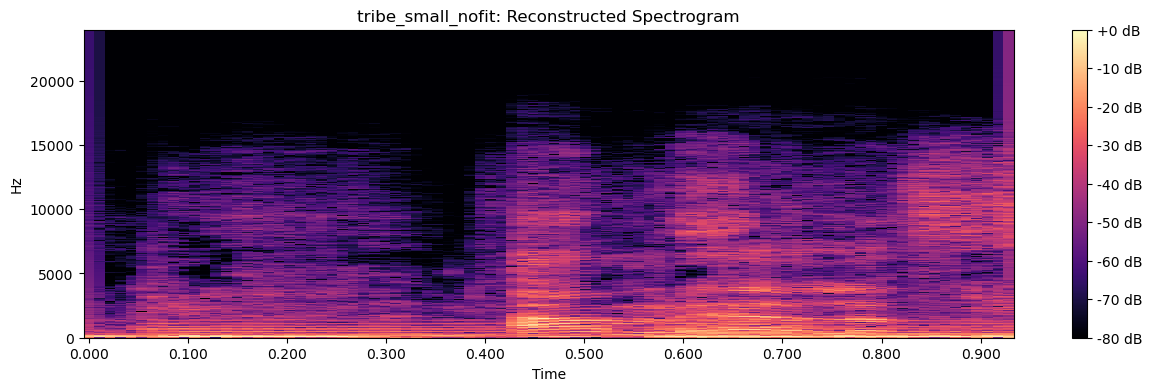

In [26]:
full_pipeline("samples/Bas - Tribe with J.Cole.mp3", save_dir='tribe_small_nofit', testname='tribe_small_nofit', chunks=256, chunk_num=128)

Time: 0.7000350952148438
RMSE of reconstruction: 0.012160959600966794
Sample reconstruction complete -> starting FFT
FFT Complete -> constructing charts


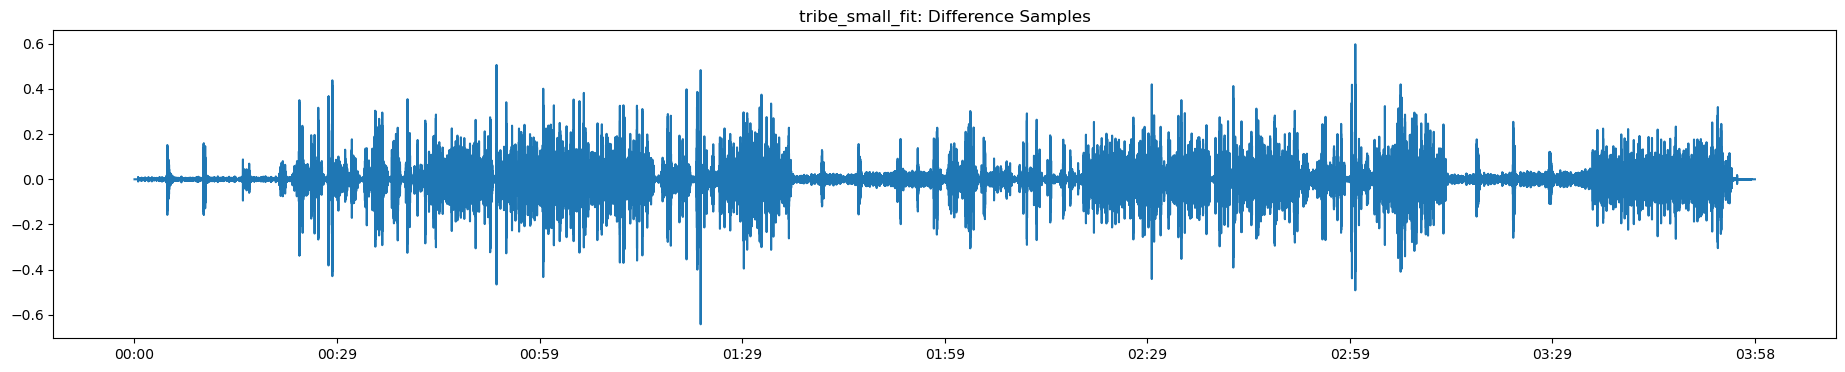

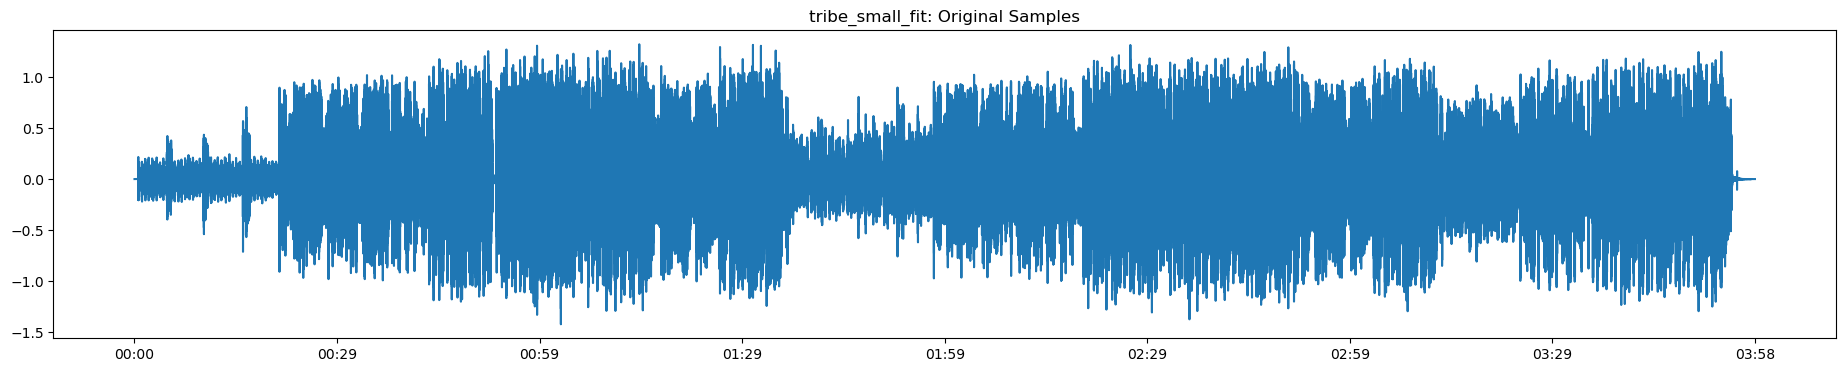

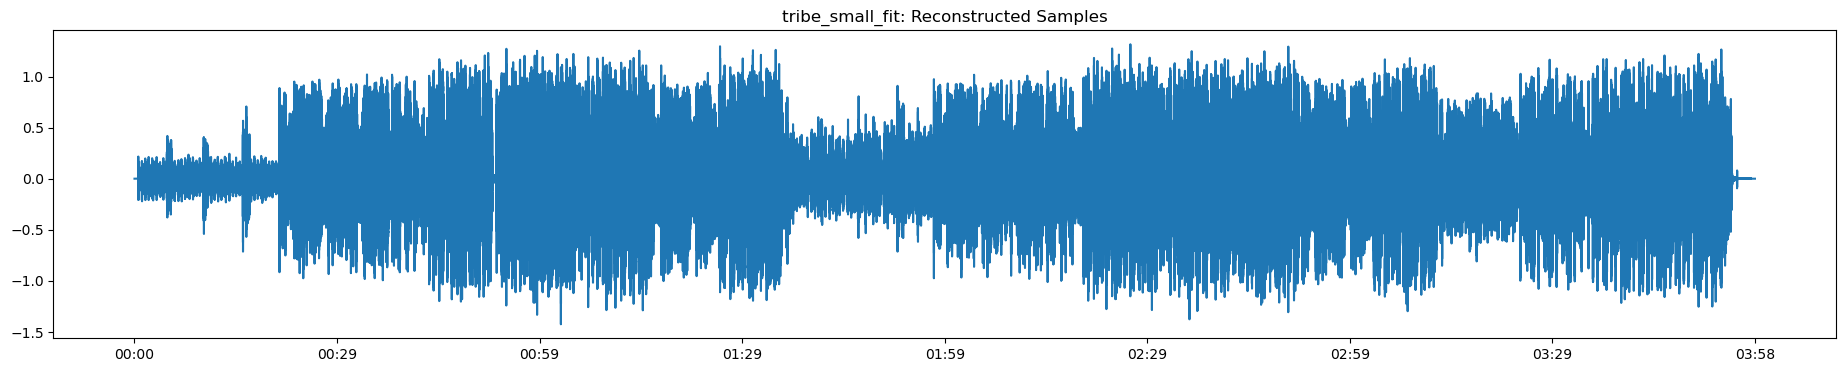

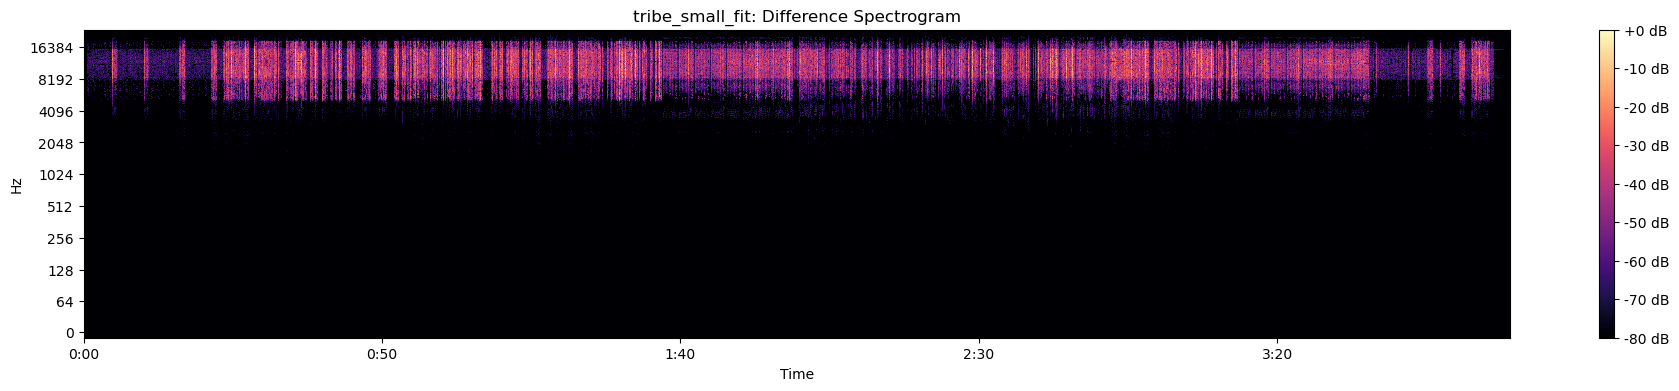

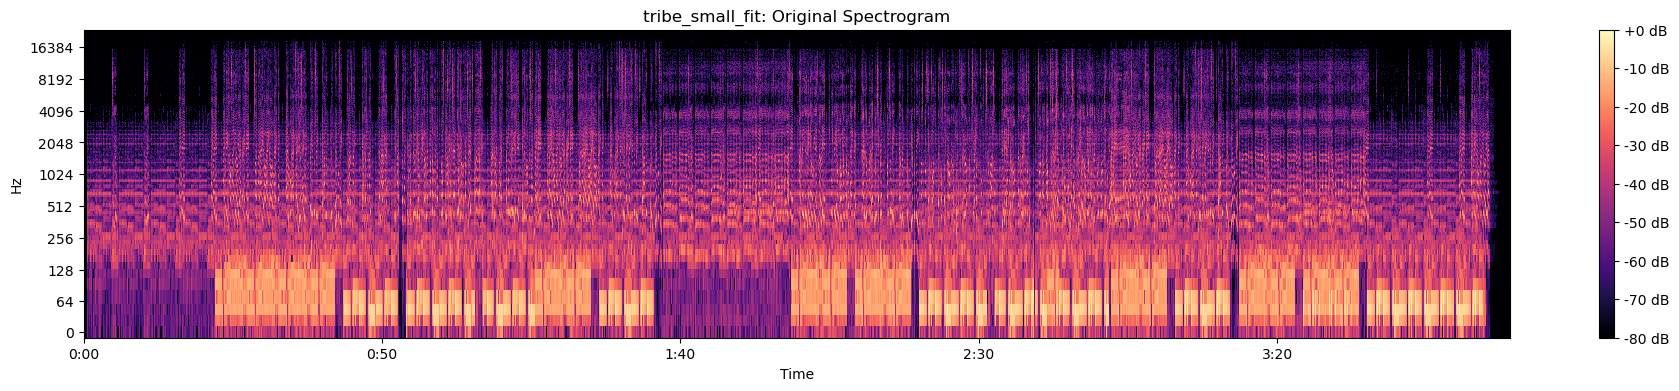

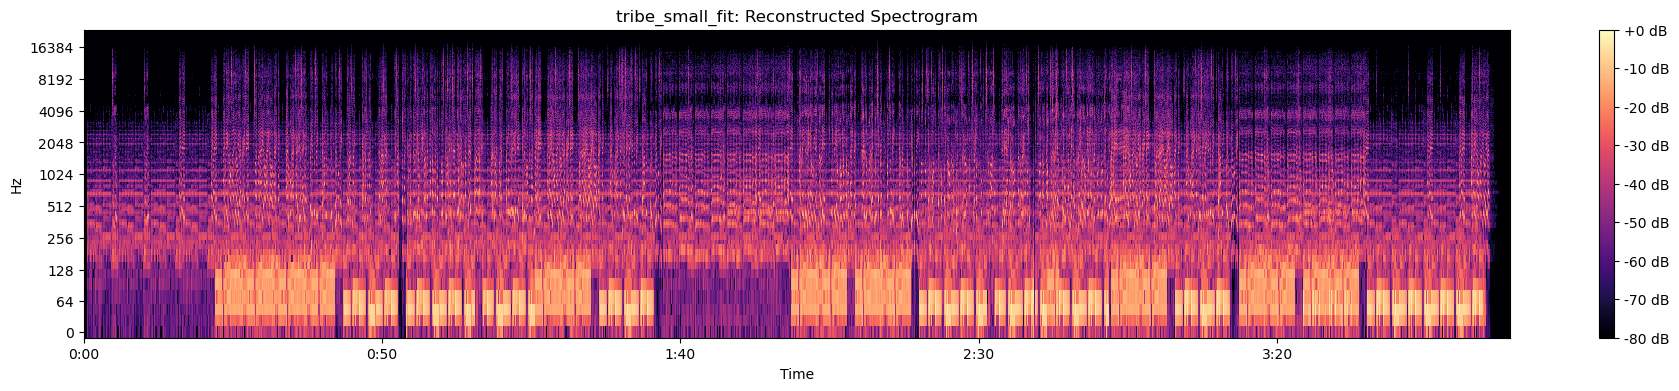

In [12]:
full_pipeline("samples/Bas - Tribe with J.Cole.mp3", save_dir='tribe_small_fit', testname='tribe_small_fit')#, chunks=256, chunk_num=128)